Griffin Shelor\
10-4-2024

# In-Class Exercise: Cartopy Maps

In [1]:
# standard python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# a handy trick to get rid of deprecation warnings
import warnings
warnings.filterwarnings("ignore") 

# mapping tools!!!
from netCDF4 import Dataset as netcdf_dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.feature import ShapelyFeature
import cartopy.io.shapereader as shpreader

### Load and clean some datasets

In [2]:
# For Q1 and Q2
earthquakes = pd.read_csv("lecture20_eq.csv")

In [3]:
# For Q3
topo_grav=netcdf_dataset('lecture13_grav.grd') 
x_range = np.array(topo_grav.variables['x_range'])
print(x_range)
y_range = np.array(topo_grav.variables['y_range'])
print(y_range)
zgrav = np.array(topo_grav.variables['z'])
dimension = np.array(topo_grav.variables['dimension'])
nx = dimension[0]
ny = dimension[1]
xgrav = np.linspace(x_range[0],x_range[1],nx)
ygrav = np.linspace(y_range[1],y_range[0],ny) # Note y needs to be reversed
zgrav = zgrav.reshape(ny,nx)

[-91.   -87.65]
[20.  22.7]


In [4]:
# For Q4

# read in county data (will need to unzip this folder before doing this)
reader = shpreader.Reader('c_05mr24/c_05mr24.shp')
records = list(reader.records())

# load ag data
adf = pd.read_csv("lecture20_farm_producers.csv")
idx = (adf["State ANSI"].isna())|(adf["County ANSI"].isna())
adf = adf[~(idx)].reset_index(drop=True)
adf["FIPS"] = ["{:02d}{:03.0f}".format(xx,yy) for (xx,yy) in zip(adf["State ANSI"], adf["County ANSI"])]
adf["Value"] = adf["Value"].str.replace(",","").astype("int")

# map FIPS to Value in the ag dataset
fipsD = dict( zip(adf["FIPS"].values,adf["Value"].values) )

# loop over all records, update with a value to plot
for x in records:
    fips = x.attributes["FIPS"]
    if fips in fipsD:
        x.attributes["Value"] = fipsD[fips]
    else:
        x.attributes["Value"] = np.nan
        

### Q1. Make 2 `DataFrames`: one that only contains earthquakes with magnitudes >= 7, and one that contains earthquakes with magnitudes >= 6 but < 7. Print the shape of both `DataFrames`.

In [5]:
## subsetting earthquakes
big_quakes = earthquakes[earthquakes["Magnitude"] >= 7.0]
medium_quakes = earthquakes[(earthquakes["Magnitude"] < 7.0) & (earthquakes["Magnitude"] >= 6.0)]

print(big_quakes.shape)
print(medium_quakes.shape)

(738, 21)
(6616, 21)


In [6]:
big_quakes.head()

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
11,01/24/1965,00:11:17,-2.608,125.952,Earthquake,20.0,NaN,NaN,8.2,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM861299,ISCGEM,ISCGEM,ISCGEM,Automatic
16,02/04/1965,05:01:22,51.251,178.715,Earthquake,30.3,NaN,NaN,8.7,MW,...,NaN,NaN,NaN,NaN,NaN,OFFICIAL19650204050122_30,OFFICIAL,ISCGEM,OFFICIAL,Automatic
26,02/04/1965,08:40:44,51.443,179.605,Earthquake,30.0,NaN,NaN,7.3,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM859264,ISCGEM,ISCGEM,ISCGEM,Automatic
62,02/23/1965,22:11:47,-25.633,-70.679,Earthquake,35.0,NaN,NaN,7.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860516,ISCGEM,ISCGEM,ISCGEM,Automatic
87,03/14/1965,15:53:07,36.405,70.724,Earthquake,207.8,NaN,NaN,7.4,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM858598,ISCGEM,ISCGEM,ISCGEM,Automatic


### Q2. Using the `Mollweide()` projection, make a global map of earthquakes with magnitudes >= 7 with blue circles and markersizes of 5.0, and earthquakes with magnitudes >= 6 and < 7 with red circles and markersizes of 1.5. Be sure to use `transform` like in the lecture. Add a legend to your plot.

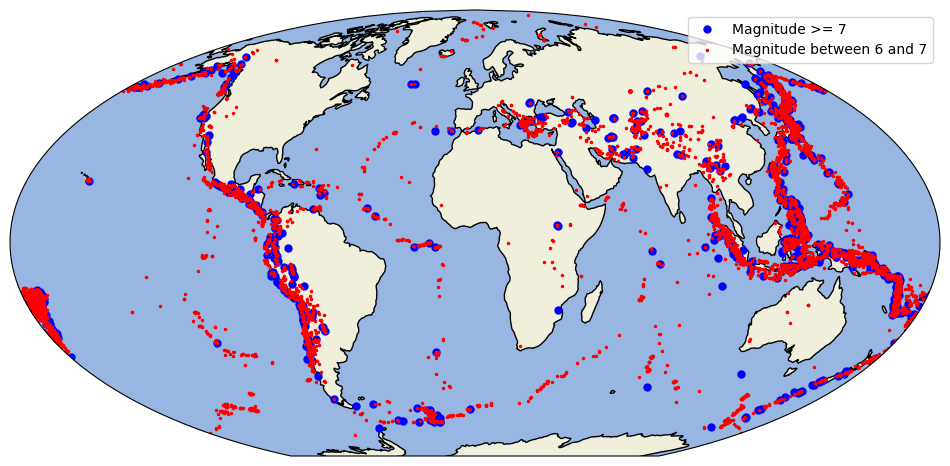

In [7]:
# Figure setup
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.Mollweide())
# Add projected features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
# ax.add_feature(cfeature.BORDERS,linestyle='-')
ax.coastlines()
plt.plot(big_quakes['Longitude'], big_quakes['Latitude'], 'bo', markersize=5.0, 
          transform=ccrs.PlateCarree(), label = "Magnitude >= 7")
plt.plot(medium_quakes['Longitude'], medium_quakes['Latitude'], 'ro', markersize=1.5, 
          transform=ccrs.PlateCarree(), label = "Magnitude between 6 and 7")
plt.legend(loc = "best");

### Q3. Use `plt.contourf()` to make a plot of the gravity data loaded in cell 3 using the `Mercator()` projection. 

* Add the coastlines, then plot the location of IODP Site M0077 (-89.94937, 21.45015) as a white triangle with blue outline (use `plt.plot()` with `transform` for this).
* Add x and y ticks labels - you can use your image from Lecture 13 inclass as a guide in choosing tickmarks, or the x_range and y_range of the grid data (see cell 3).
* Also include a colorbar (the gravity unit is mgal). 

Note: you are seeing the gravity over the Chicxulub impact crater - the center of the crater is right on the coastline!

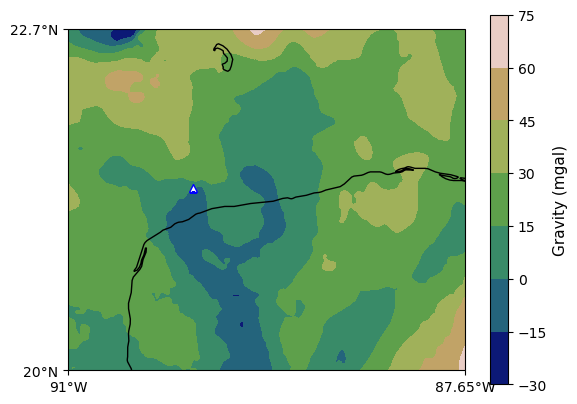

In [8]:
ax = plt.axes(projection=ccrs.Mercator())

ax.coastlines()

## making a contour plot
plt.contourf(xgrav, ygrav, zgrav, cmap='gist_earth',
             transform=ccrs.PlateCarree())
plt.plot(-89.94937, 21.45015, marker = '^', mfc = 'white', mec = 'blue', transform = ccrs.PlateCarree())

# Add Ticks
ax.set_xticks(x_range, crs=ccrs.PlateCarree())
ax.set_yticks(y_range, crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter()) # formats as degrees
ax.yaxis.set_major_formatter(LatitudeFormatter())

# Make a colorbar
cb = plt.colorbar()
cb.set_label('Gravity (mgal)', fontsize=11);

### Q4. Using the farm producer dataset from lecture (loaded in the top cell), make a plot of producer count by county in Texas. Chose a different colormap than the one used in lecture.

* First, reproduce the background map function `draw_canv()` from lecture with a modified `extent` to plot Texas rather than California/Nevada.
* Next, extract a subset of `records` corresponding to only Texas counties.
* Finally, apply the `count_choropleth()` function defined below to create the Texas choropleth map, using whatever colormap you like.  

In [9]:
### Use this function in your solution below, it creates a choropleth map by county

# input the record data, axis, the attribute to draw, and the colormap name
def county_choropleth(data, ax, attr, cmap_name):

    # additional matplotlib stuff
    from matplotlib.colors import Normalize
    from matplotlib import colormaps
    
    # We need to normalize the values before we can use the colormap.
    values = np.array([c.attributes[attr] for c in data])
    norm = Normalize(vmin=np.min(values), vmax=np.max(values))
    cmap = colormaps[cmap_name]

    # plot data, one county at a time
    for c in data:
        v = c.attributes[attr] # extract the data value to plot with this county
        sp = ShapelyFeature(c.geometry, crs=ccrs.PlateCarree(),
                            edgecolor=None, facecolor=cmap(norm(v)))
        ax.add_feature(sp)

    # add a colorbar, the scatter is a kluge to get it to link to the data above
    sc = ax.scatter(0*values-999, 0*values-999, s=0.000001+0*values, c=values,
                   cmap=cmap, transform=ccrs.PlateCarree())
    cb = plt.colorbar(sc, ax = ax, pad=0.01, shrink=0.50, aspect=30, extend="both")
    
    # return this
    return ax, cb

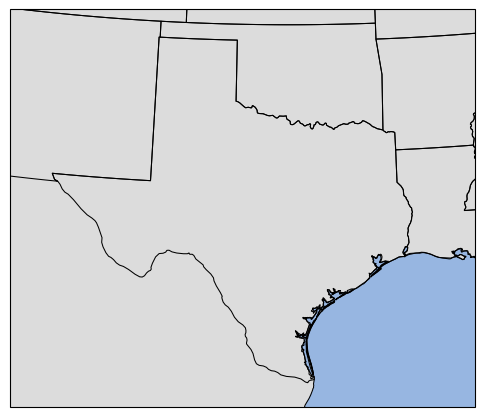

In [10]:
# setup projection
crs = ccrs.LambertConformal(central_longitude=-98)
extent = [-107.358651, -91.761440, 24.932490, 37.099340]

# simple drawing
def draw_canv(ax, extent): # a geoaxis
    ax.set_extent(extent)
    ax.add_feature(cfeature.LAND.with_scale("50m"), color="gainsboro")
    ax.add_feature(cfeature.OCEAN.with_scale("50m"))
    ax.add_feature(cfeature.STATES.with_scale("50m"), edgecolor="black", linewidth=0.75)
    ax.coastlines(linewidth=0.75)

# test this out
fig, ax = plt.subplots(1, 1, figsize=(6, 8), subplot_kw=dict(projection=crs))
draw_canv(ax, extent)

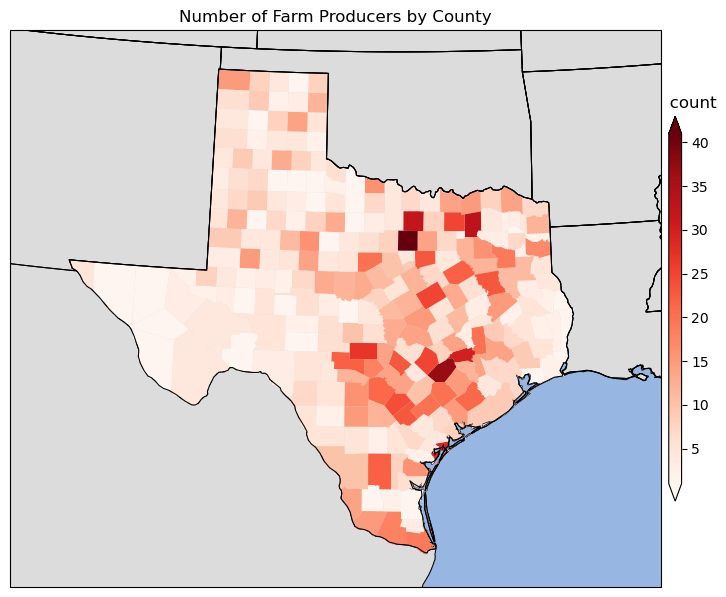

In [13]:
## just texas counties
# subset by state
tx_counties = [c for c in records if c.attributes['STATE'] in['TX']] 
# create figure
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw=dict(projection=crs))

# draw basemap
draw_canv(ax, extent)

# add data
ax, cb = county_choropleth(tx_counties, ax, 'Value', 'Reds')

# formatting
cb.ax.set_title("       count")
ax.add_feature(cfeature.STATES.with_scale("50m"),edgecolor="black",linewidth=0.75) # redraw after county overlap
ax.set_title('Number of Farm Producers by County');

### Save your notebook and output an html version. To receive credit for this in-class exercise, upload both python notebook itself and an .html file version.